# "Find quality wine with machine learning algorithms"
> "Playing with the popular wine dataset"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Peiyi Hung
- categories: [project]
- image: "images/wine.png"

# Introduction

In this project, I will build machine learning models to find high quality wines (with quaity greater than and equal to 7). The data is obtained from the UCI machine learning repository ([here](https://archive.ics.uci.edu/ml/datasets/wine+quality)) oringinating from [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub).

The analysis proceeds in this order:
* preliminary data processing: import the data and merge the datasets
* data exploring
* preprocessing before modeling
* determine the evaluation metric
* train and tune models

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams["figure.dpi"] = 100

import warnings
warnings.filterwarnings('ignore')

# Preliminary Data processing

**Import Data**

In [2]:
red = pd.read_csv("data/winequality-red.csv", sep=";")
white = pd.read_csv("data/winequality-white.csv", sep=";")

In [3]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


The data contains:
* ingredients: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, sulphates
* properties: density, pH, alcohol, quality

Next, we need to combine two datasets into one and add a 'type' variable.

In [7]:
white["type"] = "white"
red["type"] = "red"

wine = pd.concat([white, red], axis=0)
wine = wine.sample(frac=1).reset_index(drop=True) #shuffle

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.1,0.25,0.28,1.6,0.052,46.0,169.0,0.99260,3.05,0.41,10.5,5,white
1,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
2,7.7,0.12,0.32,1.4,0.060,47.0,150.0,0.99520,3.37,0.42,9.2,6,white
3,6.4,0.42,0.46,8.4,0.050,58.0,180.0,0.99495,3.18,0.46,9.7,6,white
4,8.5,0.28,0.34,13.8,0.041,32.0,161.0,0.99810,3.13,0.40,9.9,6,white


# Explore the data

Information about the dataset:

In [15]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


The dataset contains 13 variable, 11 numerical and 1 categorical. It has 6497 observations in it with no missing values. `quality` is our target variable and the others are our independent variables.

**Quality**

First, let's see the distribution of our target variable `qualty`.

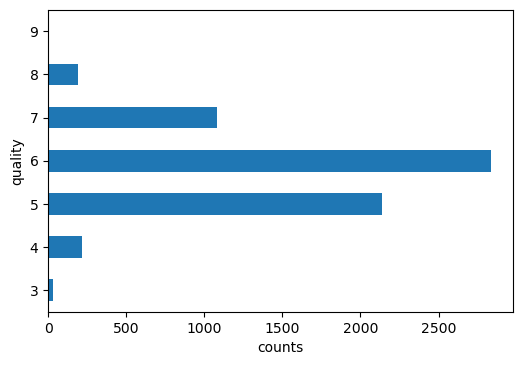

In [33]:
# count values and sort by quality
wine_value_counts = wine.quality.value_counts().sort_index()

# draw a bar chart
wine_value_counts.plot(kind='barh')
plt.ylabel("quality")
plt.xlabel("counts");

In [28]:
(wine_value_counts.cumsum()/6497).round(2)

3    0.00
4    0.04
5    0.37
6    0.80
7    0.97
8    1.00
9    1.00
Name: quality, dtype: float64

We can know 80% of wine in our data set has quality lower than 6. Based on this information, we consider wine with quality higher than 6 as high quality wine.

**Correlations**

Next, we investigate which independent variable is correlated with our target `quality`.

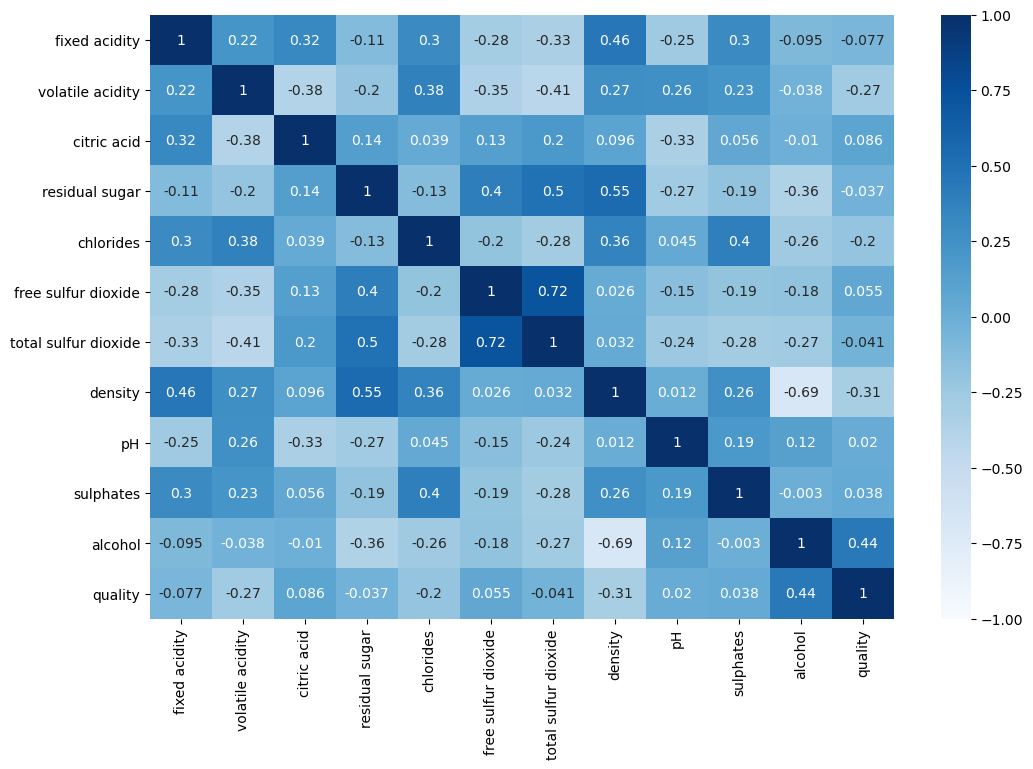

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(wine.corr(), cmap="Blues", annot=True, vmin=-1);

Three variables are correlated with "quality": "alcohol", "density", and "chlorides". Using boxplots, we can observe the distribution of these three variables between wines with different quality:

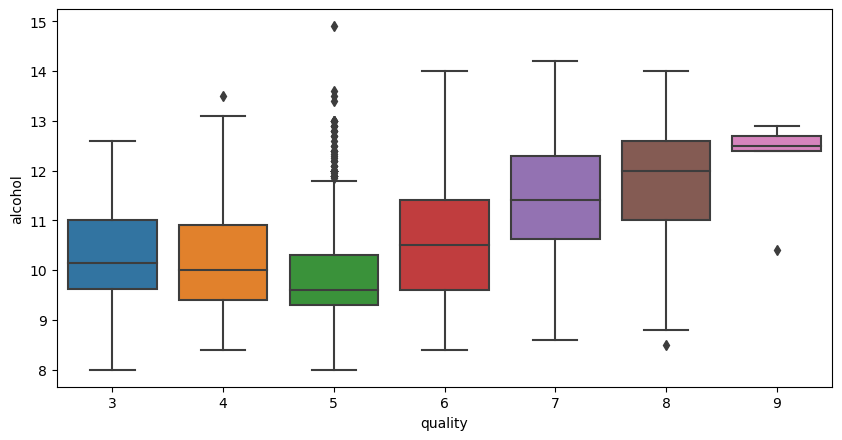

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(y="alcohol", x="quality", data=wine);

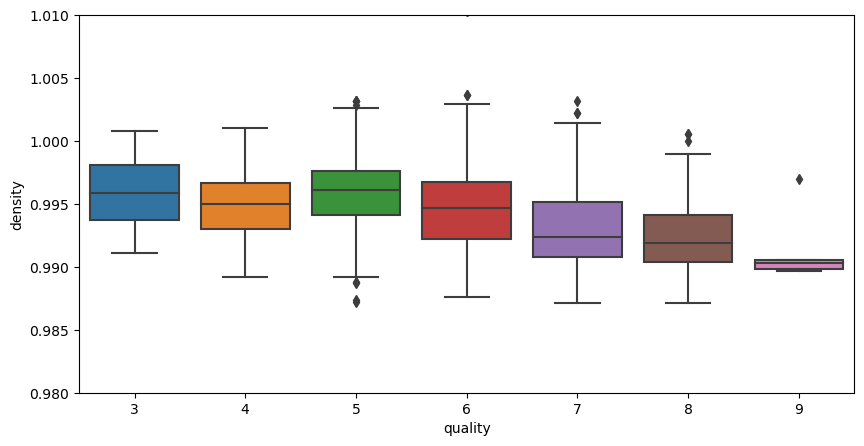

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(y="density", x="quality", data=wine)
plt.ylim(0.98, 1.01);

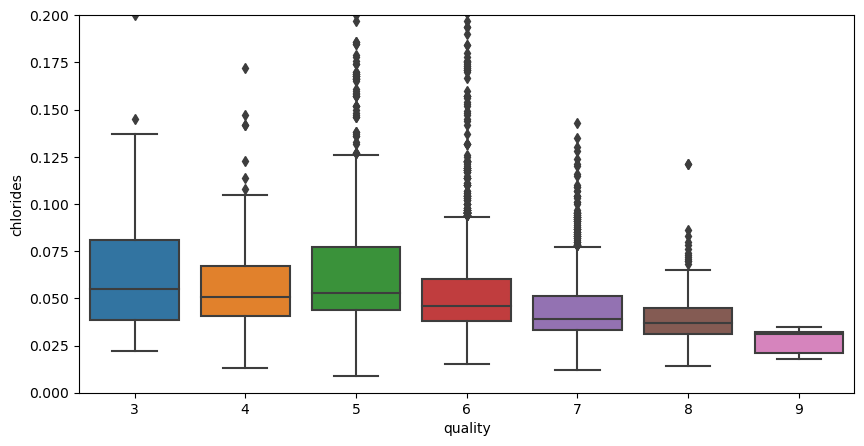

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(y="chlorides", x="quality", data=wine)
plt.ylim(0, 0.2);

___

# Predictive Modeling - is high quality or not?

Now that we have a preliminary understanding of the data, we can start to build our models. However, the data set requires some modifications to be consumed by our machine learning models.

## Preprocessing

Three modifications are conducted:
* form independent variables and the target
* standardizing and label encoding
* split train and test sets

**form independent variables and the target**

In [41]:
wine["isHigh"] = wine.quality.apply(lambda x:1 if x >= 7 else 0)

X = wine.drop(["quality", "isHigh"], axis=1)
y = wine.isHigh.values

**standardizing and label encoding**

In [44]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

num_cols = X.columns[:-1]
cat_cols = X.columns[-1]

std_scaler = StandardScaler()
X.loc[:, num_cols] = std_scaler.fit_transform(X[num_cols])

lbl_enc = LabelEncoder()
X.loc[:, cat_cols] = lbl_enc.fit_transform(X[cat_cols])

**split train and test sets**

In [45]:
wine.isHigh.value_counts()/6497

0    0.803448
1    0.196552
Name: isHigh, dtype: float64

Since the target variable is unbalaned, we split our data set in a stratified order.

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Evaluation metric

Since we get an unbalanced dataset, f1 score is used as the evaluation metric. Here we write a function to evaluate our predicting result:

In [47]:
from sklearn.metrics import confusion_matrix, f1_score

def print_metric(y_true, y_pred):
    
    f1 = f1_score(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred),
                             index=["True_low", "True_high"],
                             columns=["Pred_low", "Pred_high"])
    
    print(f"F1 score: {f1:.4f}")
    print()
    print(confusion)

## Models and Hyperparameter tuning

Four models are considered:
* baseline: use the mean of each class
* logistic regression
* random forest
* xgboost

### Baseline method - use the mean of each class

This method determine if a wine is high quality by computing the distance between the mean values of high-quality wine and low-quality wine.

In [49]:
# compute the mean value of each variable of two classes
def compute_mean(X, y):
    high_mean = X[y == 1].mean(0)
    low_mean = X[y == 0].mean(0)
    return high_mean, low_mean

# to compute the distance to high_mean and low_mean
def wine_distance(x1, x2):return (x1-x2).abs().mean(1)

# make predictions by the distance
def is_high(x, X_train, y_train):
    high_mean, low_mean = compute_mean(X_train, y_train)
    return wine_distance(x, high_mean) < wine_distance(x, low_mean) 

# make predictions
y_pred = is_high(X_test, X_train, y_train)
print_metric(y_test, y_pred)

F1 score: 0.4806

           Pred_low  Pred_high
True_low        863        443
True_high        78        241


Now, we start using machine learning models

### Machine learning models

We use a hold-out test set to evaluate the final performance and use 5-fold cross-validation as tuning procedure.

Here are function implementing the stratified cv precedures:

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

strat_cv = StratifiedKFold(n_splits=5, shuffle=True)

# a function to show cv result without tuning
def get_cv_result(model):
    """Take into a model and return cv f1 score"""
    cv_score = cross_val_score(model, 
                           X=X_train,
                           y=y_train,
                           scoring='f1',
                           cv=strat_cv,
                           n_jobs=-1)
    print(f"Mean CV score: {cv_score.mean():.4f}")
    print(f"Std: {cv_score.std():.4f}")

# a function using random search to tuning the hyperparameters
def tuning(model, params):

    randomCV = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        cv=strat_cv, 
        n_jobs=-1,
        scoring="f1",
        n_iter=50
    ).fit(X_train, y_train)

    print(f"Best f1 score: {randomCV.best_score_:.4f}")
    print("Best parameters:")
    
    for para, value in randomCV.best_params_.items():
        print(f"  {para:10}: {value:.4f}")
    
    return randomCV.best_estimator_

In the following subsection, we will first train the model without tuning and then tune the model so that we can see the improvement after tuning.

**Logistic Regression**

In [33]:
logit = LogisticRegression()
get_cv_result(logit);

Mean CV score: 0.3594
Std: 0.0265


In [35]:
logit_params = {"C":np.linspace(0.001, 100, 200)}

logit_tuned = tuning(logit, logit_params)

Best f1 score: 0.3558
Best parameters:
  C         : 6.0311


In [36]:
logit_tuned.fit(X_train, y_train)
y_pred = logit_tuned.predict(X_test)

print_metric(y_test, y_pred)

F1 score: 0.3684

           Pred_low  Pred_high
True_low       1253         53
True_high       235         84


**Random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
get_cv_result(rf)

Mean CV score: 0.6275
Std: 0.0314


In [33]:
# parameters we try
rf_params = {
    "n_estimators":np.arange(100, 1500), 
    "max_depth":np.arange(1, 50),
    "max_features":[0.3,  0.5, 0.7],
    "min_samples_leaf":np.arange(1, 30)
}

rf_tuned = tuning(rf, rf_params)

Best f1 score: 0.6316
Best parameters:
  n_estimators: 160.0000
  min_samples_leaf: 1.0000
  max_features: 0.3000
  max_depth : 13.0000


In [34]:
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

print_metric(y_test, y_pred)

F1 score: 0.6415

           Pred_low  Pred_high
True_low       1265         41
True_high       149        170


**XGBoost**

In [35]:
import xgboost as xgb

xgb_cls = xgb.XGBClassifier(eval_metric="logloss",
                            use_label_encoder=False)
get_cv_result(xgb_cls)

Mean CV score: 0.6506
Std: 0.0089


In [36]:
xgb_params = {
    "n_estimators":np.arange(1, 1500),
    "max_depth":np.arange(1, 50),
    "learning_rate":np.linspace(0.01, 0.1, 100),
    "gamma":np.linspace(0.05, 1, 100),
    "min_child_weight":[1,3,5,7],
    "subsample":[0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":[0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda":np.linspace(0.01, 1, 100)
}

xgb_tuned = tuning(xgb_cls, xgb_params)

Best f1 score: 0.6647
Best parameters:
  subsample : 0.7000
  reg_lambda: 0.6900
  n_estimators: 1440.0000
  min_child_weight: 3.0000
  max_depth : 10.0000
  learning_rate: 0.0373
  gamma     : 0.6066
  colsample_bytree: 0.9000


In [37]:
xgb_tuned.fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)

print_metric(y_test, y_pred)

F1 score: 0.6667

           Pred_low  Pred_high
True_low       1251         55
True_high       132        187
